Please e-mail ejcain@email.arizona.edu or dlebauer@email.arizona.edu with any questions, or create an issue in this GitHub [repository](https://github.com/genophenoenvo/terraref-datasets).

### MAC Season 4 Data Cleaning

#### Selected Traits
- aboveground dry biomass
- canopy height
- days & growing degree days (GDD) to flowering
- days & GDD to flag leaf emergence

In [14]:
import datetime
import numpy as np
import os
import pandas as pd
import requests
import sqlite3

In [9]:
def download_csv(url, folder_name, file_name):
    response = requests.get(url)
    with open(os.path.join(folder_name, file_name), 'wb') as f:
        f.write(response.content)

In [10]:
def read_in_csv(folder_name, file_name):
    df = pd.read_csv(folder_name + '/' + file_name, low_memory=False)
    return df

In [15]:
def plot_hist(df, value_column, trait_column):
    
    trait_name = df[trait_column].unique()[0]
    return df[value_column].hist(color='navy').set_xlabel(trait_name);

In [16]:
def check_for_nulls_duplicates(df):
    
    print(
        f'Sum of null values:\n{df.isnull().sum()}\n-----\n'
        f'Value counts for duplicates:\n{df.duplicated().value_counts()}'
    )

In [17]:
def check_unique_values(df):

    for col in df.columns:
        if df[col].nunique() < 5:
            print(f'{df[col].nunique()} unique value(s) for {col} column: {df[col].unique()}')    
        else:
            print(f'{df[col].nunique()} values for {col} column')

In [18]:
def extract_range_column_values(working_df, plot_column):
    
    new_df = working_df.copy()
    new_df['range'] = new_df[plot_column].str.extract("Range (\d+)").astype(int)
    new_df['column'] = new_df[plot_column].str.extract("Column (\d+)").astype(int)
    
    return new_df

In [19]:
def convert_datetime_column(working_df, date_column):
    
    new_datetimes = pd.to_datetime(working_df[date_column])
    new_df_0 = working_df.drop(labels=date_column, axis=1)
    new_df_1 = new_df_0.copy()
    new_df_1['date'] = new_datetimes
    
    return new_df_1

In [20]:
def rename_value_column(working_df, value_column, trait_column):
    
    trait = working_df[trait_column].unique()[0]
    new_df_0 = working_df.rename({value_column: trait}, axis=1)
    new_df_1 = new_df_0.drop(labels=trait_column, axis=1)
    
    return new_df_1

Blocking height experiment description for season 4 can be found [here](https://terraref.ncsa.illinois.edu/bety/api/v1/experiments?name=~MAC+Season+4:+All+BAP+With+Late+Season+Drought)


In [21]:
def add_season_4_blocking_height(working_df, range_column):
    
    short_blocks = [11, 20, 46, 50]
    medium_blocks = [10, 12, 18, 24, 27, 29, 31, 33, 38, 51]
    tall_blocks = [3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26, 28, 30, 32, 34, 35, 36, 37, 
                   39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 52]
    border = [1, 2, 53, 54]
    
    range_values = working_df[range_column].values
    blocking_heights = []
    
    for r in range_values:
        
        if r in short_blocks:
            blocking_heights.append('short')
            
        elif r in medium_blocks:
            blocking_heights.append('medium')
            
        elif r in tall_blocks:
            blocking_heights.append('tall')
            
        elif r in border:
            blocking_heights.append('border')
            
        else:
            print(f'Error with range value {r}')
        
    working_df_1 = working_df.copy()
    working_df_1['blocking_height'] = blocking_heights
    
    return working_df_1

In [22]:
def reorder_columns(working_df, new_col_order_list):
    
    working_df_1 = pd.DataFrame(data=working_df, columns=new_col_order_list)
    return working_df_1

In [23]:
def check_for_subplots(df, plot_col):

    for name in df[plot_col].values:
        if (name.endswith(' E')) | (name.endswith(' W')):
             return 'This dataset contains subplot designations'
        else:
            return 'No subplot designations'

In [24]:
def strip_subplots(working_df, plot_col, new_plot_col_name):
    
    plot_names = working_df[plot_col].values
    new_plot_names = []
    
    for n in plot_names:
        if (n.endswith(' E') | (n.endswith(' W'))):
            new_plot_names.append(n[:-2])    
        else:
            new_plot_names.append(n)
            
    working_df_1 = working_df.drop(labels=plot_col, axis=1)
    working_df_2 = working_df_1.copy()
    
    working_df_2[new_plot_col_name] = new_plot_names
    return working_df_2

In [25]:
def save_to_csv_with_timestamp(df, name_of_dataset):
    
    timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()
    output_filename = ('data/processed/' + f'{name_of_dataset}_' + f'{timestamp}.csv').replace(':', '')

    df.to_csv(output_filename, index=False)

In [26]:
def save_to_csv_without_timestamp(list_of_dfs, list_of_output_filenames):

    for i,j in zip(list_of_dfs, list_of_output_filenames):
        i.to_csv(j, index=False)

#### MAC Season 4

In [4]:
folder_name = 'data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [3]:
season_4_url = 'https://de.cyverse.org/dl/d/D3168AC5-82BE-436E-B8B5-AB8DD78CAF28/mac_season_four_2020-04-22.csv'
season_4_input_filename = 'raw_mac_season_4_data.csv.'

In [13]:
download_csv(season_4_url, folder_name=folder_name, file_name=season_4_input_filename)

In [50]:
df = read_in_csv(folder_name=folder_name, file_name=season_4_input_filename)
# print(df.shape)

In [51]:
cols_to_drop = ['Unnamed: 0', 'checked', 'result_type', 'id', 'citation_id', 'site_id', 'treatment_id', 
                'scientificname', 'commonname', 'genus', 'species_id', 'cultivar_id', 'author', 
                'citation_year', 'time', 'month', 'year', 'n', 'statname', 'stat', 'notes', 'access_level', 
                'entity', 'view_url', 'edit_url', 'date', 'dateloc', 'city', 'treatment']

df_1 = df.drop(labels=cols_to_drop, axis=1)
# print(df_1.shape)
# df_1.head(3)

(375150, 10)


,sitename,lat,lon,raw_date,trait,trait_description,mean,units,cultivar,method_name
0,MAC Field Scanner Season 4 Range 40 Column 6,33.075949,-111.974966,2017-06-08 14:00:00 -0500,leaf_angle_beta,NaN,2.033237,NaN,PI329841,3D scanner to leaf angle distribution
1,MAC Field Scanner Season 4 Range 40 Column 6,33.075949,-111.974966,2017-06-08 14:00:00 -0500,leaf_angle_chi,NaN,2.523958,NaN,PI329841,3D scanner to leaf angle distribution
2,MAC Field Scanner Season 4 Range 40 Column 6,33.075949,-111.974966,2017-06-19 14:00:00 -0500,leaf_angle_mean,NaN,0.373537,normalized degrees,PI329841,3D scanner to leaf angle distribution


In [52]:
df_2 = extract_range_column_values(df_1, 'sitename')
# print(df_2.shape)
# df_2.sample(n=3)

(375150, 12)


,sitename,lat,lon,raw_date,trait,trait_description,mean,units,cultivar,method_name,range,column
85611,MAC Field Scanner Season 4 Range 33 Column 2,33.075698,-111.975032,2017-06-24 14:00:00 -0500,leaf_angle_alpha,NaN,4.163588,NaN,PI181080,3D scanner to leaf angle distribution,33,2
269258,MAC Field Scanner Season 4 Range 53 Column 14,33.076417,-111.974836,2017-06-28 14:00:00 -0500,leaf_angle_alpha,NaN,3.189180,NaN,Big_Kahuna,3D scanner to leaf angle distribution,53,14
63923,MAC Field Scanner Season 4 Range 4 Column 3,33.074655,-111.975015,2017-08-29 14:00:00 -0500,leaf_angle_chi,NaN,1.807663,NaN,PI646251,3D scanner to leaf angle distribution,4,3


In [53]:
df_3 = convert_datetime_column(df_2, 'raw_date')
# df_3.head(3)

,sitename,lat,lon,trait,trait_description,mean,units,cultivar,method_name,range,column,date
0,MAC Field Scanner Season 4 Range 40 Column 6,33.075949,-111.974966,leaf_angle_beta,NaN,2.033237,NaN,PI329841,3D scanner to leaf angle distribution,40,6,2017-06-08 14:00:00-05:00
1,MAC Field Scanner Season 4 Range 40 Column 6,33.075949,-111.974966,leaf_angle_chi,NaN,2.523958,NaN,PI329841,3D scanner to leaf angle distribution,40,6,2017-06-08 14:00:00-05:00
2,MAC Field Scanner Season 4 Range 40 Column 6,33.075949,-111.974966,leaf_angle_mean,NaN,0.373537,normalized degrees,PI329841,3D scanner to leaf angle distribution,40,6,2017-06-19 14:00:00-05:00


#### A. Aboveground Dry Biomass

In [54]:
adb_0 = df_3.loc[df['trait'] == 'aboveground_dry_biomass']
# print(adb_0.shape)
# adb_0.head()

(867, 12)


,sitename,lat,lon,trait,trait_description,mean,units,cultivar,method_name,range,column,date
2799,MAC Field Scanner Season 4 Range 30 Column 5,33.075590,-111.974983,aboveground_dry_biomass,Aboveground Dry Biomass,22040.0,kg / ha,PI152727,Whole above ground biomass at harvest,30,5,2017-09-12 00:00:00-05:00
7651,MAC Field Scanner Season 4 Range 30 Column 9,33.075590,-111.974917,aboveground_dry_biomass,Aboveground Dry Biomass,12940.0,kg / ha,PI329518,Whole above ground biomass at harvest,30,9,2017-09-15 00:00:00-05:00
22687,MAC Field Scanner Season 4 Range 2 Column 5,33.074584,-111.974982,aboveground_dry_biomass,Aboveground Dry Biomass,37330.0,kg / ha,SP1615,Whole above ground biomass at harvest,2,5,2017-09-12 00:00:00-05:00
22688,MAC Field Scanner Season 4 Range 11 Column 7,33.074907,-111.974949,aboveground_dry_biomass,Aboveground Dry Biomass,22030.0,kg / ha,PI656015,Whole above ground biomass at harvest,11,7,2017-09-12 00:00:00-05:00
22689,MAC Field Scanner Season 4 Range 22 Column 7,33.075302,-111.974950,aboveground_dry_biomass,Aboveground Dry Biomass,32030.0,kg / ha,PI330196,Whole above ground biomass at harvest,22,7,2017-09-12 00:00:00-05:00


Text(0.5, 0, 'aboveground_dry_biomass')

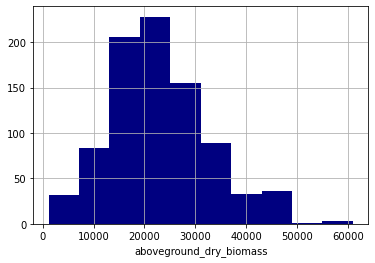

In [55]:
# plot_hist(adb_0, 'mean', 'trait')

In [56]:
# check_for_nulls_duplicates(adb_0)

Sum of null values:
sitename             0
lat                  0
lon                  0
trait                0
trait_description    0
mean                 0
units                0
cultivar             0
method_name          0
range                0
column               0
date                 0
dtype: int64
-----
Value counts for duplicates:
False    544
True     323
dtype: int64


In [65]:
adb_1 = adb_0.drop_duplicates(ignore_index=True)
# print(adb_1.shape)
# adb_1.head(3)

(544, 12)


,sitename,lat,lon,trait,trait_description,mean,units,cultivar,method_name,range,column,date
0,MAC Field Scanner Season 4 Range 30 Column 5,33.075590,-111.974983,aboveground_dry_biomass,Aboveground Dry Biomass,22040.0,kg / ha,PI152727,Whole above ground biomass at harvest,30,5,2017-09-12 00:00:00-05:00
1,MAC Field Scanner Season 4 Range 30 Column 9,33.075590,-111.974917,aboveground_dry_biomass,Aboveground Dry Biomass,12940.0,kg / ha,PI329518,Whole above ground biomass at harvest,30,9,2017-09-15 00:00:00-05:00
2,MAC Field Scanner Season 4 Range 2 Column 5,33.074584,-111.974982,aboveground_dry_biomass,Aboveground Dry Biomass,37330.0,kg / ha,SP1615,Whole above ground biomass at harvest,2,5,2017-09-12 00:00:00-05:00


In [66]:
# check_for_subplots(adb_1, 'sitename')

'No subplot designations'

In [67]:
adb_2 = rename_value_column(adb_1, 'mean', 'trait')
# print(adb_2.shape)
# adb_2.tail()

(544, 11)


,sitename,lat,lon,trait_description,aboveground_dry_biomass,units,cultivar,method_name,range,column,date
539,MAC Field Scanner Season 4 Range 44 Column 5,33.076093,-111.974983,Aboveground Dry Biomass,33770.0,kg / ha,PI156268,Whole above ground biomass at harvest,44,5,2017-09-12 00:00:00-05:00
540,MAC Field Scanner Season 4 Range 40 Column 13,33.075949,-111.974852,Aboveground Dry Biomass,22540.0,kg / ha,PI569148,Whole above ground biomass at harvest,40,13,2017-09-16 00:00:00-05:00
541,MAC Field Scanner Season 4 Range 50 Column 7,33.076309,-111.974950,Aboveground Dry Biomass,22150.0,kg / ha,PI154988,Whole above ground biomass at harvest,50,7,2017-09-12 00:00:00-05:00
542,MAC Field Scanner Season 4 Range 52 Column 6,33.076381,-111.974967,Aboveground Dry Biomass,30780.0,kg / ha,PI152751,Whole above ground biomass at harvest,52,6,2017-09-12 00:00:00-05:00
543,MAC Field Scanner Season 4 Range 52 Column 7,33.076381,-111.974950,Aboveground Dry Biomass,35770.0,kg / ha,PI329299,Whole above ground biomass at harvest,52,7,2017-09-12 00:00:00-05:00


In [68]:
adb_3 = add_season_4_blocking_height(adb_2, 'range')
# print(adb_3.shape)
# adb_3.sample(n=3)

(544, 12)


,sitename,lat,lon,trait_description,aboveground_dry_biomass,units,cultivar,method_name,range,column,date,blocking_height
457,MAC Field Scanner Season 4 Range 49 Column 6,33.076273,-111.974966,Aboveground Dry Biomass,23670.0,kg / ha,PI570038,Whole above ground biomass at harvest,49,6,2017-09-12 00:00:00-05:00,tall
484,MAC Field Scanner Season 4 Range 40 Column 2,33.075949,-111.975032,Aboveground Dry Biomass,27310.0,kg / ha,PI329310,Whole above ground biomass at harvest,40,2,2017-09-11 00:00:00-05:00,tall
415,MAC Field Scanner Season 4 Range 37 Column 8,33.075842,-111.974934,Aboveground Dry Biomass,20910.0,kg / ha,PI562970,Whole above ground biomass at harvest,37,8,2017-09-12 00:00:00-05:00,tall


In [71]:
new_col_order = ['date', 'sitename', 'range', 'column', 'lat', 'lon', 'cultivar', 'aboveground_dry_biomass', 
                 'units', 'method_name', 'blocking_height']

adb_4 = reorder_columns(adb_3, new_col_order)
# print(adb_4.shape)
# adb_4.head(3)

(544, 11)


,date,sitename,range,column,lat,lon,cultivar,aboveground_dry_biomass,units,method_name,blocking_height
0,2017-09-12 00:00:00-05:00,MAC Field Scanner Season 4 Range 30 Column 5,30,5,33.075590,-111.974983,PI152727,22040.0,kg / ha,Whole above ground biomass at harvest,tall
1,2017-09-15 00:00:00-05:00,MAC Field Scanner Season 4 Range 30 Column 9,30,9,33.075590,-111.974917,PI329518,12940.0,kg / ha,Whole above ground biomass at harvest,tall
2,2017-09-12 00:00:00-05:00,MAC Field Scanner Season 4 Range 2 Column 5,2,5,33.074584,-111.974982,SP1615,37330.0,kg / ha,Whole above ground biomass at harvest,border


#### B. Canopy Height - Sensor

In [ ]:
ch_0 = pd.read_csv('data/raw/season_4_traits/season_4_canopy_height_sensor.csv')
print(ch_0.shape)
# ch_0.head()

In [ ]:
# check_unique_values(ch_0)

In [ ]:
check_for_nulls_duplicates(ch_0)

#### Drop duplicates

In [ ]:
ch_1 = ch_0.drop_duplicates(ignore_index=True)
print(ch_1.shape)
check_for_nulls_duplicates(ch_1)

In [ ]:
check_for_subplots(ch_1, 'plot')

In [ ]:
ch_2 = extract_range_column_values(ch_1, 'plot')
print(ch_2.shape)
# ch_2.sample(n=3)

In [ ]:
ch_3 = convert_datetime_column(ch_2, 'date')
print(ch_3.shape)
# ch_3.dtypes

In [ ]:
ch_4 = rename_value_column(ch_3, 'mean', 'trait')
print(ch_4.shape)
# ch_4.tail(3)

In [ ]:
ch_5 = add_season_4_blocking_height(ch_4, 'range')
# ch_5.sample(n=3)

In [ ]:
ch_6 = ch_5.drop(labels=['checked', 'author', 'season'], axis=1)
print(ch_6.shape)

#### Add units column
- cm

In [ ]:
ch_7 = ch_6.copy()
ch_7['units'] = 'cm'
print(ch_7.shape)
# ch_7.head(3)

In [ ]:
new_col_order = ['date', 'plot', 'range', 'column', 'scientificname', 'genotype', 'treatment', 'blocking_height', 
                 'method', 'canopy_height', 'units', 'method_type']

ch_8 = reorder_columns(ch_7, new_col_order)
print(ch_8.shape)
ch_8.head(3)

#### C. Canopy Height - Manual
- using SQLite for `groupby`

In [ ]:
chm_0 = pd.read_csv('data/raw/season_4_traits/season_4_canopy_height_manual.csv')
print(chm_0.shape)
# chm_0.head()

In [ ]:
check_for_nulls_duplicates(chm_0)

In [ ]:
# check_unique_values(chm_0)

In [ ]:
chm_1 = extract_range_column_values(chm_0, 'plot')
print(chm_1.shape)
# chm_1.sample(n=3)

In [ ]:
chm_2 = convert_datetime_column(chm_1, 'date')
print(chm_2.shape)
# chm_2.head()

#### Identify and Remove Subplot Designations

In [ ]:
check_for_subplots(chm_2, 'plot')

In [ ]:
chm_3 = strip_subplots(chm_2, 'plot', 'plot')
print(chm_3.shape)
# chm_3.sample(n=3)

In [ ]:
check_for_subplots(chm_3, 'plot')

In [ ]:
# check for plot/date/mean/treatment duplicates

chm_3.duplicated(subset=['plot', 'date', 'mean', 'treatment']).value_counts()

In [ ]:
# Drop Duplicates

chm_4 = chm_3.drop_duplicates(ignore_index=True, subset=['plot', 'genotype', 'treatment', 'mean', 'range', 'column',
                                                        'date'])

print(chm_4.shape)
chm_4.duplicated().value_counts()

In [ ]:
chm_5 = add_season_4_blocking_height(chm_4, 'range')
print(chm_5.shape)
# chm_5.sample(n=3)

#### Use sqlite database to group by `plot`, `date`, and `mean` 
- rename `mean` to `canopy_height_cm`
- can also drop and reorder columns at this time

In [ ]:
conn = sqlite3.connect('data/interim/canopy_heights_manual_season_4.sqlite')
cursor = conn.cursor()
print("Opened database successfully")

In [ ]:
# comment next line out if db has already been created
chm_5.to_sql('canopy_heights_manual_season_4.sqlite', conn)

In [ ]:
chm_6 = pd.read_sql_query("""
                            SELECT date, plot, range, column, scientificname, genotype, treatment, blocking_height,
                            method, ROUND(AVG([mean]), 2) AS canopy_height_cm, method_type
                            FROM 'canopy_heights_manual_season_4.sqlite'
                            GROUP BY plot, date,[mean]
                            ORDER BY date ASC;
                            """, conn)

print(chm_6.shape)
chm_6.head(3)

#### D. Days & GDD to Flowering

In [ ]:
fl_0 = pd.read_csv('data/raw/season_4_traits/season_4_flowering_time_manual.csv')
print(fl_0.shape)
# fl_0.head()

#### Read in updated processed weather dataset for season 4

In [ ]:
weather_0 = pd.read_csv('data/processed/mac_season_4_daily_weather_2020-07-01T144735.csv')
print(weather_0.shape)
# weather_0.head()

In [ ]:
plot_hist(fl_0, 'mean', 'trait')

In [ ]:
check_for_nulls_duplicates(fl_0)

In [ ]:
check_for_subplots(fl_0, 'plot')

In [ ]:
# check_unique_values(fl_0)

#### Add planting date 2017-04-20

In [ ]:
day_of_planting = datetime.date(2017,4,20)
flower_df_1 = fl_0.copy()

flower_df_1['date_of_planting'] = day_of_planting
print(flower_df_1.shape)
# flower_df_1.head(3)

#### Create datetime with days to flowering (`mean`)

In [ ]:
timedelta = pd.Series([pd.Timedelta(days=i) for i in flower_df_1['mean'].values])
dates_of_flowering = []

for td in timedelta:
    
    date_of_flowering = day_of_planting + td
    dates_of_flowering.append(date_of_flowering)
    
print(flower_df_1.shape[0])
print(len(dates_of_flowering))

In [ ]:
flower_df_2 = flower_df_1.copy()
flower_df_2['date_of_flowering'] = dates_of_flowering
print(flower_df_2.shape)
# flower_df_2.head(3)

#### Add GDD to flowering dataframe

In [ ]:
# slice weather df for date and cumulative gdd values only

season_4_gdd = weather_0[['date', 'gdd']]
print(season_4_gdd.shape)
# season_4_gdd.head(3)

In [ ]:
season_4_gdd.dtypes

In [ ]:
flower_df_3 = flower_df_2.copy()
flower_df_3.date_of_flowering = pd.to_datetime(flower_df_3.date_of_flowering)
# flower_df_3.dtypes

In [ ]:
season_4_gdd_1 = season_4_gdd.copy()
season_4_gdd_1['date'] = pd.to_datetime(season_4_gdd_1['date'])
season_4_gdd_1.dtypes

In [ ]:
flower_df_4 = flower_df_3.merge(season_4_gdd_1, how='left', left_on='date_of_flowering', right_on='date')
print(flower_df_4.shape)
# flower_df_4.head(3)

In [ ]:
flower_df_5 = extract_range_column_values(flower_df_4, 'plot')
flower_df_6 = add_season_4_blocking_height(flower_df_5, 'range')

print(flower_df_6.shape)
# flower_df_6.tail(3)

In [ ]:
flower_df_7 = rename_value_column(flower_df_6, 'mean', 'trait')
# flower_df_7.sample(n=3)

In [ ]:
flower_df_8 = flower_df_7.rename({'flowering_time': 'days_to_flowering', 'gdd': 'gdd_to_flowering'}, axis=1)
# flower_df_8.head(2)

In [ ]:
cols_to_drop = ['date_x', 'checked', 'author', 'season', 'date_of_planting', 'date_y']

flower_df_9 = flower_df_8.drop(labels=cols_to_drop, axis=1)
print(flower_df_9.shape)
# flower_df_9.sample(n=3)

In [ ]:
new_col_order = ['plot', 'range', 'column', 'scientificname', 'genotype', 'treatment', 'blocking_height', 
                 'method', 'date_of_flowering', 'days_to_flowering', 'gdd_to_flowering', 'method_type']

flower_df_10 = reorder_columns(flower_df_9, new_col_order)
print(flower_df_10.shape)
flower_df_10.head(3)

#### E. Days & GDD to Flag Leaf Emergence

In [ ]:
fle_0 = pd.read_csv('data/raw/season_4_traits/season_4_flag_leaf_emergence_time_manual.csv')
print(fle_0.shape)
# fle_0.head()

#### Read in updated processed weather dataset for season 4
Code used to process weather data for season 4 can be found in the `season_4_weather_data_cleaning` notebook in this repository

In [ ]:
weather_0 = pd.read_csv('data/processed/mac_season_4_daily_weather_2020-07-01T144735.csv')
print(weather_0.shape)
# weather_0.head()

In [ ]:
plot_hist(fle_0, 'mean', 'trait')

In [ ]:
check_for_nulls_duplicates(fle_0)

In [ ]:
check_for_subplots(fle_0, 'plot')

In [ ]:
# check_unique_values(fle_0)

#### Add planting date 2017-04-20

In [ ]:
day_of_planting = datetime.date(2017,4,20)
fle_df_1 = fle_0.copy()

fle_df_1['date_of_planting'] = day_of_planting
print(fle_df_1.shape)
# fle_df_1.head(3)

#### Create timedelta using days to flag leaf emergence (`mean`)

In [ ]:
timedelta = pd.Series([pd.Timedelta(days=i) for i in fle_df_1['mean'].values])
dates_of_flag_leaf_emergence = []

for td in timedelta:
    
    date_of_flag_leaf_emergence = day_of_planting + td
    dates_of_flag_leaf_emergence.append(date_of_flag_leaf_emergence)
    
print(fle_df_1.shape[0])
print(len(dates_of_flag_leaf_emergence))

In [ ]:
fle_df_2 = fle_df_1.copy()
fle_df_2['date_of_flag_leaf_emergence'] = dates_of_flag_leaf_emergence
print(fle_df_2.shape)
# fle_df_2.head(3)

#### Add GDD values to flag leaf emergence dataframe

In [ ]:
# slice weather df for date and cumulative gdd values only

season_4_gdd = weather_0[['date', 'gdd']]
print(season_4_gdd.shape)
# season_4_gdd.head(3)

In [ ]:
fle_df_3 = fle_df_2.copy()
fle_df_3.date_of_flag_leaf_emergence = pd.to_datetime(fle_df_3.date_of_flag_leaf_emergence)
# fle_df_3.dtypes

In [ ]:
season_4_gdd_1 = season_4_gdd.copy()
season_4_gdd_1['date'] = pd.to_datetime(season_4_gdd_1['date'])
season_4_gdd_1.dtypes

In [ ]:
fle_df_4 = fle_df_3.merge(season_4_gdd_1, how='left', left_on='date_of_flag_leaf_emergence', right_on='date')
print(fle_df_4.shape)
# fle_df_4.head(3)

In [ ]:
fle_df_5 = extract_range_column_values(fle_df_4, 'plot')
fle_df_6 = add_season_4_blocking_height(fle_df_5, 'range')

print(fle_df_6.shape)
# fle_df_6.tail(3)

In [ ]:
fle_df_7 = rename_value_column(fle_df_6, 'mean', 'trait')
# fle_df_7.sample(n=3)

In [ ]:
fle_df_8 = fle_df_7.rename({'flag_leaf_emergence_time': 'days_to_flag_leaf_emergence', 'gdd': 'gdd_to_flag_leaf_emergence'}, axis=1)
# fle_df_8.head(2)

In [ ]:
cols_to_drop = ['date_x', 'checked', 'author', 'season', 'date_of_planting', 'date_y']

fle_df_9 = fle_df_8.drop(labels=cols_to_drop, axis=1)
print(fle_df_9.shape)
# fle_df_9.sample(n=3)

In [ ]:
new_col_order = ['plot', 'range', 'column', 'scientificname', 'genotype', 'treatment', 'blocking_height', 
                 'method', 'date_of_flag_leaf_emergence', 'days_to_flag_leaf_emergence', 
                 'gdd_to_flag_leaf_emergence', 'method_type']

fle_df_10 = reorder_columns(fle_df_9, new_col_order)
print(fle_df_10.shape)
fle_df_10.head(3)

### Save all datasets to separate csv files

In [ ]:
list_of_dfs = [adb_7, ch_8, chm_6, flower_df_10, fle_df_10]
list_of_output_filenames = ['data/processed/mac_season_4_aboveground_dry_biomass.csv',
                           'data/processed/mac_season_4_canopy_height_sensor.csv',
                           'data/processed/mac_season_4_canopy_height_manual.csv',
                           'data/processed/mac_season_4_days_gdd_to_flowering.csv',
                           'data/processed/mac_season_4_days_gdd_to_flag_leaf_emergence.csv']

In [ ]:
save_to_csv_without_timestamp(list_of_dfs, list_of_output_filenames)